In [1]:
# Just testing my Spatial AE

import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision

from torch.utils.data import TensorDataset, DataLoader, random_split

#from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import *
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

!pwd
! echo $CONDA_PREFIX 

Using cuda device
/home/mag/predictive-coding-thesis/src
/home/mag/miniconda3/envs/predictive-code


### Training the Predictive Coder model

In [3]:
# downsampling to 64x64

downsample = False

if downsample:
    import cv2
    data_dir = 'data/face-north'
    prefix = 'frames' 
    for filename in os.listdir(data_dir):
        if filename.startswith(prefix) and not os.path.isdir(filename):
            frames_path = os.path.join(data_dir, filename)
            frames = np.load(frames_path)
            downsampled_images = []

            for frame in frames:
                resized_img = cv2.resize(frame, (64, 64), interpolation=cv2.INTER_AREA)
                downsampled_images.append(resized_img)
    
            downsampled_stack = np.stack(downsampled_images, axis=0)
            np.save(frames_path, downsampled_stack)
            

In [4]:
# preprocess data by removing consecutive repeat frames
remove_repeats = False

if remove_repeats:
    from utils.data_processing import remove_consecutive_repeats
    
    data_dir = 'data/face-north'
    prefix = 'coords' 
    for filename in os.listdir(data_dir):
        if filename.startswith(prefix):
            file_suffix = filename[len(prefix):]
            coords_path = os.path.join(data_dir, filename)
            frames_path = os.path.join(data_dir, 'frames' + file_suffix)
            
            kept_idx = remove_consecutive_repeats(coords_path)
            
            coords = np.load(coords_path)
            frames = np.load(frames_path)
            np.save(coords_path, coords[kept_idx])
            np.save(frames_path, frames[kept_idx])
            print(f'removed {len(coords) - len(kept_idx)} from {filename}')
            
            del coords
            del frames

In [5]:
torch.manual_seed(321)

# need to consider if you actually want to transform
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = 'data/face-north'
target_dir_name = 'frames'

dataset = SequentialFrameDataset(source_directory=data_dir, 
                                 target_directory_name=target_dir_name,
                                 transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')

batch_size = 36
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

print(torch.cuda.memory_allocated(device))

Assuming already indexed files in data/face-north/frames
71884 training samples
0


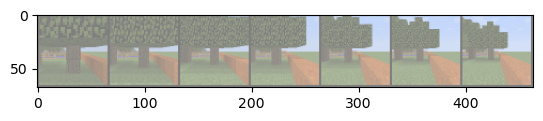

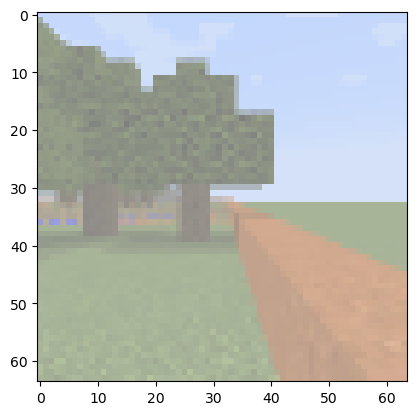

In [6]:
# Take a look at the sequence of images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq, preds = next(iter(train_loader))
imshow(torchvision.utils.make_grid(seq[0]))
imshow(preds[0])

In [7]:
model = PredictiveCoder()
model.to(device)
print(len(train_loader))

num_epochs = 200 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.1
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


1997


In [ ]:

model_file = f'model_files/facenorth_{train_ratio}_samples-{num_epochs}ep-2.pt'
train_losses_file = f'logs/facenorth-ep{num_epochs}-train_{train_ratio}-2.txt'
test_losses_file = f'logs/facenorth-ep{num_epochs}-test_{train_ratio}-2.txt'

train_losses = []
test_losses = []

try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, device)
        test_loss = test(test_loader, model, loss_fn, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
        lr_scheduler.step()
    
        torch.save(model.state_dict(), model_file)

finally:
    torch.save(model.state_dict(), model_file)
    
    with open(train_losses_file, 'w') as fp:
        for s in train_losses:
            fp.write("%s\n" % s)
            
    with open(test_losses_file, 'w') as fp:
        for x in test_losses:
            fp.write("%s\n" % x)

    print("Done!")


Epoch 1
-------------------------------
loss: 0.150206  [    0/71884]
loss: 0.017511  [36000/71884]
Test Error: 
 Avg loss: 0.016978 

Epoch 2
-------------------------------
loss: 0.019140  [    0/71884]
loss: 0.013028  [36000/71884]
Test Error: 
 Avg loss: 0.014498 

Epoch 3
-------------------------------
loss: 0.014019  [    0/71884]
loss: 0.013028  [36000/71884]
Test Error: 
 Avg loss: 0.013135 

Epoch 4
-------------------------------
loss: 0.011022  [    0/71884]
loss: 0.011574  [36000/71884]
Test Error: 
 Avg loss: 0.012053 

Epoch 5
-------------------------------
loss: 0.013438  [    0/71884]
loss: 0.012912  [36000/71884]
Test Error: 
 Avg loss: 0.011510 

Epoch 6
-------------------------------
loss: 0.012518  [    0/71884]
loss: 0.012721  [36000/71884]
Test Error: 
 Avg loss: 0.011303 

Epoch 7
-------------------------------
loss: 0.009915  [    0/71884]
loss: 0.010928  [36000/71884]
Test Error: 
 Avg loss: 0.010879 

Epoch 8
-------------------------------
loss: 0.010364 

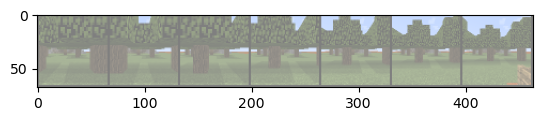

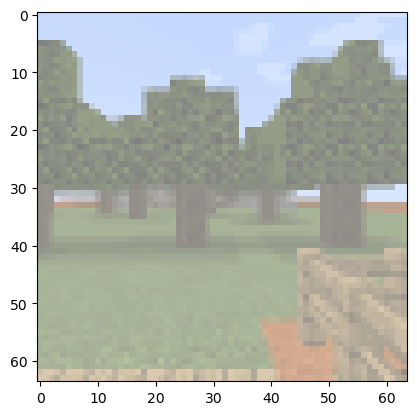

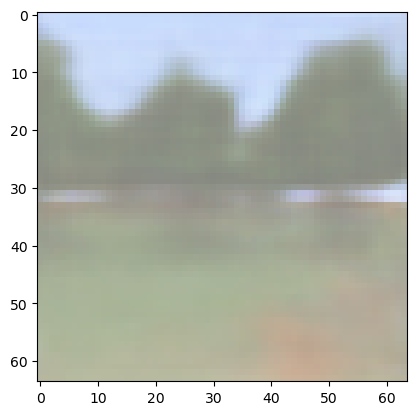

In [62]:
seq, corr = next(iter(test_loader))

imshow(torchvision.utils.make_grid(seq[0]))
imshow(corr[0])

with torch.no_grad():
    pred = model(seq.to(device)).cpu() # won't this have issues with a batch norm or something if you have one batch

imshow(pred[0])


### Train an MLP to predict location from latent values

In [ ]:
# This is dumb, but I need to remove the head direction stuff at least for now from coords

def remove_head_dir(coords_dir):
    for filename in os.listdir(coords_dir):
        filepath = os.path.join(coords_dir, filename)
        data = np.load(filepath, mmap_mode='r')
        data = np.delete(data, 2, axis=1)
        np.save(filepath, data)
        del data

remove_head_dir('data/worldone-indexed/coords')

In [20]:
coords_dir = 'data/worldone-indexed/coords'

for filename in os.listdir(coords_dir):
    filepath = os.path.join(coords_dir, filename)
    data = np.load(filepath, mmap_mode='r').astype(np.float32)
    np.save(filepath, data)
    del data

In [21]:
# Load in the coordinate data
data_dir = 'data'
target_dir_name = 'worldone-indexed'

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CoordinateDataset(source_directory=data_dir, 
                            target_directory_name=target_dir_name,
                            transform=transform)

train_ratio = math.floor(len(dataset) * 0.9)
train_data, test_data = random_split(dataset, [train_ratio, len(dataset) - train_ratio])
print(f'{train_ratio} training samples')
batch_size = 10
# does it matter in this instance if you shuffle? I think you can get away with it
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

Assuming already indexed frame files in data/worldone-indexed/frames
Assuming already indexed coords files in data/worldone-indexed/coords
27720 training samples


In [22]:
# Set up the model, which takes as input my trained predictive coder encoder and attn

latent_model_file = f'model_files/worldone_fixedhead_27720_samples.pt'
loc_predictor_file = latent_model_file[:-3] + '_predictor.pt'

latent_model = PredictiveCoder()
latent_model.load_state_dict(torch.load(latent_model_file))
latent_model.eval()
for param in latent_model.parameters():
    param.requires_grad = False

model = LocationPredictor(latent_model)
model.to(device)

num_epochs = 5
steps_per_epoch = len(train_loader)

learning_rate = 0.01
weight_decay = 0.0001

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)


In [ ]:
train_losses_file = 'logs/pred-loc-fixedhead-train.txt'
test_losses_file = 'logs/pred-loc-fixedhead-test.txt'

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch} train loss: {test_loss}')
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)

with open(train_losses_file, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")


Epoch 1
-------------------------------
loss: 328879.500000  [    0/27720]
loss: 61.748158  [10000/27720]
loss: 111.687698  [20000/27720]


In [6]:
# checking to see if I've covered most of the space since this model is really not perfect.

import datetime

directory = 'data/'
coordinates = set()
total_len = 0
for file in os.listdir(directory):
    if file.startswith('coords_'):
        data = np.load(os.path.join(directory, file))
        # Assuming the data format in each file is [x, y, yaw]
        for line in data:
            total_len += 1
            x, z = line[0], line[1]
            coordinates.add((x, z))

print('total number of frames (more than actual sequences):', total_len) 
print(len(coordinates))
print(40*65) # minus any obstacles, but should be kinda close

full_coords = set()
for x in range(-484,-427):
    for z in range(-694, -658):
        full_coords.add((x + 0.5, z + 0.5))

#print(full_coords.difference(coordinates))
# TODO remove duplicate entries from your training data

total number of frames (more than actual sequences): 91143
1647
2600


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we have two sets of data points, one for actual (ground truth) and one for predicted
# For demonstration, random points around a line y=x will be generated for actual
# and points with some added noise for predicted

np.random.seed(0) # for reproducibility

# Generate some random data for demonstration purposes
actual_x = np.linspace(-40, 40, 300)
actual_y = actual_x + np.random.normal(size=actual_x.shape) * 5  # some random noise around the line y=x

predicted_x = actual_x + np.random.normal(size=actual_x.shape) * 5  # additional noise for predicted points
predicted_y = actual_y + np.random.normal(size=actual_y.shape) * 5

# Calculate errors (distance) between actual and predicted points
errors_x = predicted_x - actual_x
errors_y = predicted_y - actual_y
errors = np.sqrt(errors_x**2 + errors_y**2)

# Create the figure and the axis
fig, ax = plt.subplots()

# Plot actual points
ax.scatter(actual_x, actual_y, color='gray', label='Actual')

# Plot predicted points
ax.scatter(predicted_x, predicted_y, color='blue', label='Predicted')

# Plot error lines
for i in range(len(actual_x)):
    ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], color='gray', linewidth=0.5)

# Set labels and title
ax.set_xlabel('x (lattice units)')
ax.set_ylabel('y (lattice units)')
ax.set_title('The predictive coder\'s latent space encodes spatial position')

# Add legend
ax.legend()

# Show the plot
plt.show()
